In [1]:
import numpy as np
from collections import Counter
import anndata
import scanpy as sc
import scrublet as scr
import matplotlib.pyplot as plt
import pandas as pd

## Pipeline

1. Load data
2. Quality control -> compute QC metrics  
3. Explore database -> get parameters and thresold to filter database
4. Filter -> by number of expressed genes, counts, mt genes... 
5. Doublet detection
6. Empty-drop identification
7. Normalization 
8. Feature selection
9. Scaling
10. PCA + Clustering + UMAP
11. Re-assess quality control and cell filtering
12. Batch effect

## 1.Load data

In [2]:
# Load AnnData objects
adata = anndata.read_h5ad("./data/adata.h5ad.gz")
print(f"Data loaded: {adata.shape} cells x genes")
# adata_somatic = anndata.read_h5ad("./data/hADSC-1013/hADSC1013_adata.h5ad.gz")
print(f"Somatic cells data: {adata[adata.obs.cell_state == 'somatic', :].shape} cells x genes")
#adata_plastic = anndata.read_h5ad("./data/hADSC-1013_SIID16/hADSC1013_SIID16_adata.h5ad.gz")
print(f"Intermediate plastic state cells data: {adata[adata.obs.cell_state == 'intermediate plastic state with a regeneration-like program', :].shape} cells x genes")

Data loaded: (10328, 32738) cells x genes
Somatic cells data: (5404, 32738) cells x genes
Intermediate plastic state cells data: (4924, 32738) cells x genes


In [3]:
adata

AnnData object with n_obs × n_vars = 10328 × 32738
    obs: 'reprogramming_type', 'reprogramming_stage', 'cell_state', 'cell_type', 'cell_line'

## 2.Compute QC metrics

QC metrics are computed in scRNA-seq data to detect broken, empty or multiple (mix of broken) cells. I mean, cells with low quality. 

Observation level metrics are: 

* total_{var_type}_by_{expr_type}: E.g. “total_genes_by_counts”. Number of genes with positive counts in a cell(expressed).
* total_{expr_type}: E.g. “total_counts”. Total number of counts for a cell.
* pct_{expr_type}_in_top_{n}_{var_type}: E.g. “pct_counts_in_top_50_genes”. Cumulative percentage of counts for 50 most expressed genes in a cell.
* total_{expr_type}_{qc_var}: E.g. “total_counts_mito”. Total number of counts for variables in qc_vars.
* pct_{expr_type}_{qc_var}: E.g. “pct_counts_mito”. Proportion of total counts for a cell which are mitochondrial.

Variable level metrics include:

* total_{expr_type}: E.g. “total_counts”. Sum of counts for a gene.
* n_genes_by_{expr_type}: E.g. “n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells.
* mean_{expr_type}: E.g. “mean_counts”. Mean expression over all cells.
* n_cells_by_{expr_type}: E.g. “n_cells_by_counts”. Number of cells this expression is measured in.
* pct_dropout_by_{expr_type}: E.g. “pct_dropout_by_counts”. Percentage of cells this feature does not appear in.

In [4]:
# Calculate quality control (QC) metrics 
# mitochondrial genes, "MT-" for human -> ESTAS SON LAS ÚNICAS QUE SE BUSCAN EN EL PAPER
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

In [5]:
# Save fields in AnnData object
adata_somatic = adata[adata.obs.cell_state == "somatic", :]
adata_plastic = adata[adata.obs.cell_state == "intermediate plastic state with a regeneration-like program", :]

## 3.Exploratory analysis

Metrics explanation: https://doi.org/10.1186%2Fs13059-016-0888-1

"*Cells with very few total counts (total_counts very low) or very few detected genes (n_genes_by_count very low) can be discarded as dead or damaged cells.*"

They demonstrate that deceptive cells != low quality. 
Low quality cells: 
1. Higher average gene expression in specific functional categories (Gene Ontology terms) compared to high quality cells
2. Gene expression in these functional categories is noisier for low versus high quality cells

Broken/multiple cells: 
1. Genes relating to Cytoplasm, Metabolism, Mitochondrion, Membrane, and a few other categories are strongly downregulated  
2. Transcriptome-wide increased noise levels compared to high quality cells.

Use SVM or Ensemble method to detect low quality cells. 

The presence of some cells with high percentages of mitochondrial counts and/or low numbers of expressed genes might signal the need for additional filtering to remove low-quality or damaged cells -> FILTER BY MT-GENES AND COUNTS

' Low quality cells' featuring one or more of:

* ⚠️ Low total counts
* ⚠️ Few expressed genes
* ⚠️ High proportion of reads coming from mitochondria
* ⚠️ High proportion of reads coming from spike-ins

We can identify them using: 

* Fixed thresholds: While simple, this strategy requires considerable experience to determine appropriate thresholds for each experimental protocol and biological system. Thresholds for read count-based data are simply not applicable for UMI-based data, and vice versa. Differences in mitochondrial activity or total RNA content require constant adjustment of the mitochondrial and spike-in thresholds, respectively, for different biological systems. Indeed, even with the same protocol and system, the appropriate threshold can vary from run to run due to the vagaries of cDNA capture efficiency and sequencing depth per cell.
* Adaptative thresholds: To obtain an adaptive threshold, we assume that most of the dataset consists of high-quality cells. We then identify cells that are outliers for the various QC metrics, based on the median absolute deviation (MAD) from the median value of each metric across all cells. Specifically, a value is considered an outlier if it is more than 3 MADs from the median in the “problematic” direction. This is loosely motivated by the fact that such a filter will retain 99% of non-outlier values that follow a normal distribution.

⚠️ Cells with both large total counts and large mitochondrial counts may be high-quality cells that happen to be highly metabolically active 


### 3.1 Counts

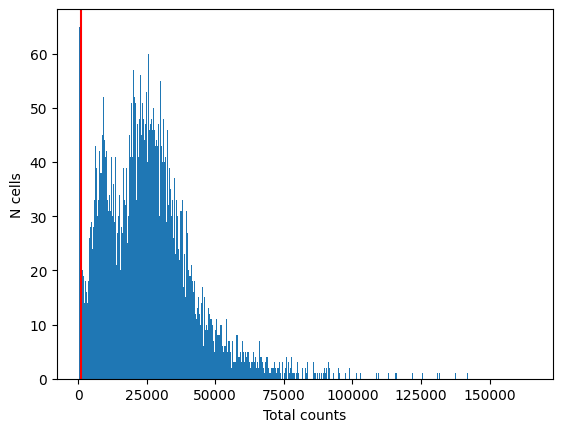

In [6]:
# First, we consider the total number of reads detected per cell
# Cells with few reads are likely to have been broken or failed to capture a cell, and should thus be removed 
plt.hist(adata.obs.total_counts, bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(1000, color='red') # Paper threshold

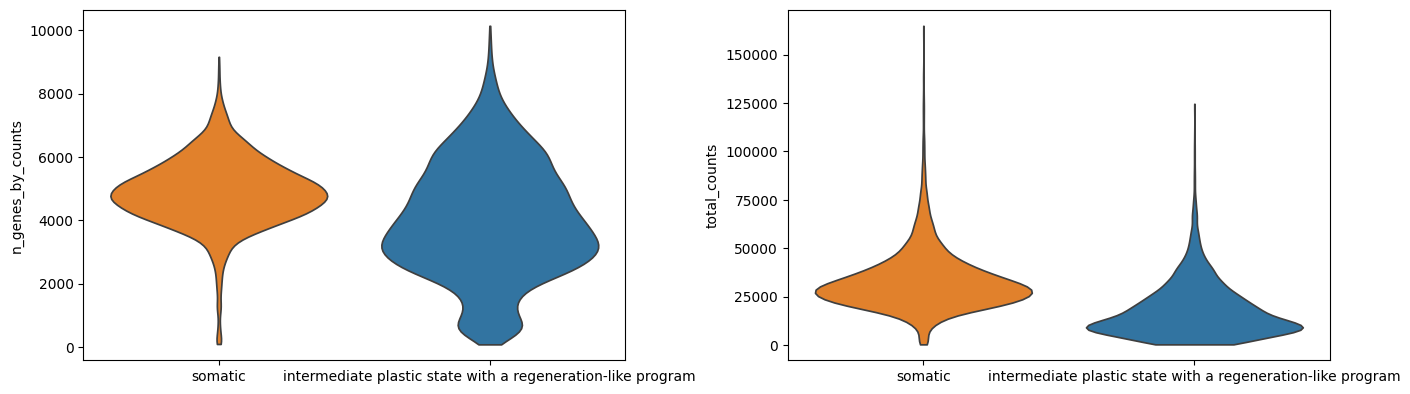

In [7]:
# Violin plot
# Counts and expressed genes in cells
groupby_order = ['somatic', 'intermediate plastic state with a regeneration-like program']
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts"],
    groupby='cell_state',
    order=groupby_order,
    xlabel=None,
    jitter=0.4,
    multi_panel=True,
    stripplot=False
)

n_genes_by_counts -> en células somáticas se expresan unos 5000 genes de mediana. Deberíamos buscar esta forma también en las células reprogramadas? En este otro caso se expresan alrededor de 3000 genes (mediana), qué influencia tiene este cambio de distribución? 

total_counts -> mayor en células somáticas (25000 de mediana). En las células plásticas empieza "de golpe", mínimo hay 10000 conteos aproximadamente, why?

### 3.2 Genes

#### Filter by genes type: mithocondrial, ribosomal, hemoglobin

In [8]:
print("---- Somatic cells ----")
print(f"Number of mithocondrial genes: {Counter(adata_somatic.var.mt).get(True,0)}")
print(f"Number of ribosomal genes: {Counter(adata_somatic.var.ribo).get(True,0)}")
print(f"Number of hemoglobin genes: {Counter(adata_somatic.var.hb).get(True,0)}")

print("\n---- Intermediate plastic state with a regeneration-like program cells ---- ")
print(f"Number of mithocondrial genes: {Counter(adata_plastic.var.mt).get(True,0)}")
print(f"Number of ribosomal genes: {Counter(adata_plastic.var.ribo).get(True,0)}")
print(f"Number of hemoglobin genes: {Counter(adata_plastic.var.hb).get(True,0)}")

---- Somatic cells ----
Number of mithocondrial genes: 13
Number of ribosomal genes: 106
Number of hemoglobin genes: 13

---- Intermediate plastic state with a regeneration-like program cells ---- 
Number of mithocondrial genes: 13
Number of ribosomal genes: 106
Number of hemoglobin genes: 13


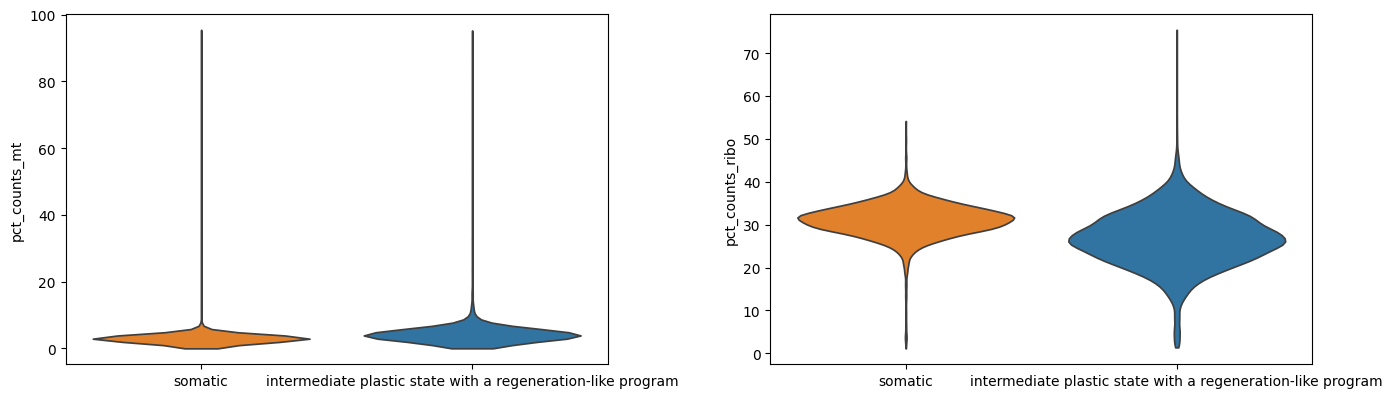

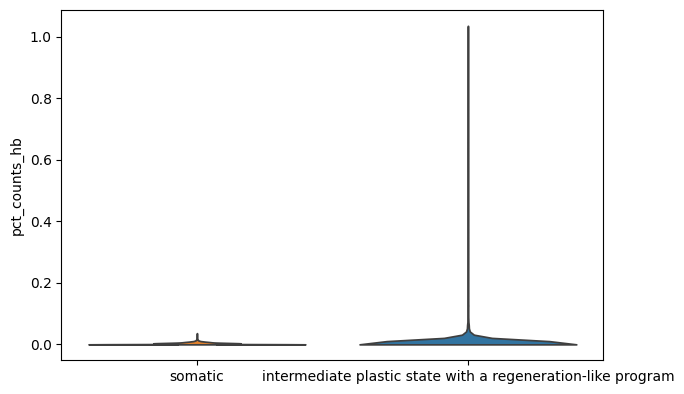

In [9]:
# % mithocondrial genes, % ribosomical genes, % hemoblogin genes
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo"],
    groupby='cell_state',
    order=groupby_order,
    xlabel=None,
    multi_panel=True,
    stripplot=False
)
sc.pl.violin(
    adata,
    ["pct_counts_hb"],
    groupby='cell_state',
    order=groupby_order,
    xlabel=None,
    multi_panel=True,
    stripplot=False
)

Los conteos de genes mitocondriales siguen la misma distribución en células somáticas y plásticas. Sin embargo, los de hemoglobina alcanzan el 100% en plásticas al contrario que en somáticas que no pasa del 10%. Por otro lado, los ribosomales también aumentan -> en qué influye? es una consecuencia "deseada"? 

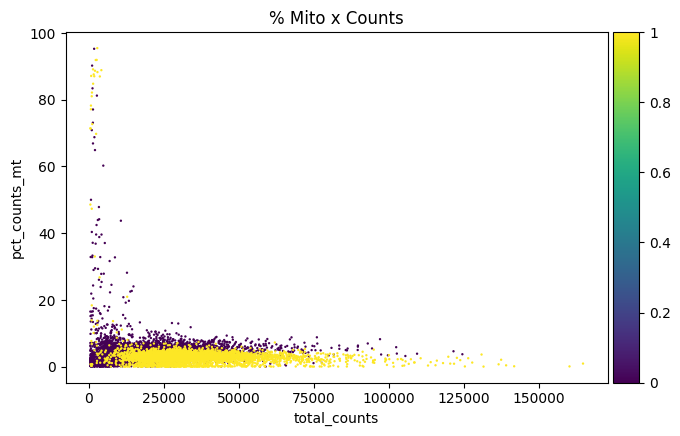

In [10]:
"""
This code shows the relationship between 'total_counts' (total number of gene expression) and 
'pct_counts_mt' (percentage of mt genes in total gene expression).
Additionally, the colors of the dots are encoded according to the 'cell_state' variable -> 1 somatic, 0 plastic
"""
from sklearn.preprocessing import LabelEncoder
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['cell_state'])
adata.obs["cell_state_encoded"] = encoder_celltype.transform(adata.obs["cell_state"])
# 1-> somatic, 0 -> plastic state

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='cell_state_encoded', title='% Mito x Counts')

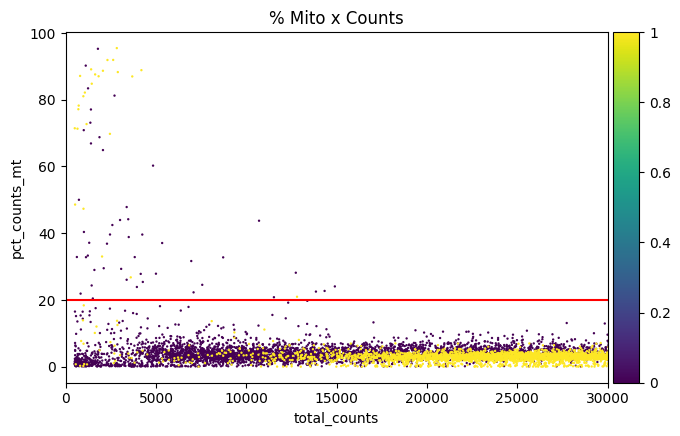

In [11]:
# Hacemos Zoom para encontrar cuándo se estabiliza el % de genes mitocondriales, en que valor y conteos
ax=sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='cell_state_encoded', title='% Mito x Counts', show=False)
ax.set_xlim(0,30000)
ax.axhline(20, color='red')

Vemos que hay muestras con 4000-5000 conteos con un % alto de genes mitocondriales. Después de esto, el valor se estabiliza alrededor del 15% de genes mitocondriales. Si queremos ser más estrictos y hacer un filtrado más radical podemos eliminar aquellos genes que tengan más del 15% de genes mitoncondriales, o dar margen hasta el 20%. Sino, podemos subir el valor del umbral. 

#### Filter by number of detected genes

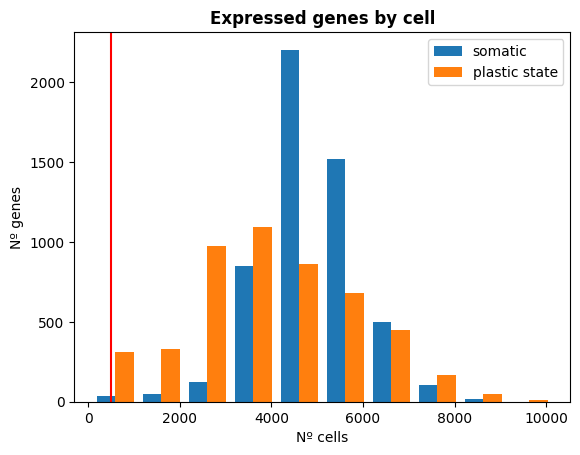

In [12]:
# In addition to ensuring sufficient sequencing depth for each sample, we also want to make sure that the reads are 
# distributed across the transcriptome. Thus, we count the total number of unique genes detected in each sample
plt.hist([adata_somatic.obs.n_genes_by_counts,adata_plastic.obs.n_genes_by_counts], label=['somatic', 'plastic state'])
plt.legend(loc='upper right')
plt.title('Expressed genes by cell', fontweight = "bold")
plt.xlabel("Nº cells")
plt.ylabel("Nº genes")
plt.axvline(500, color='red') # Paper threshold 
plt.show()

If detection rates were equal across the cells then the distribution should be approximately normal 

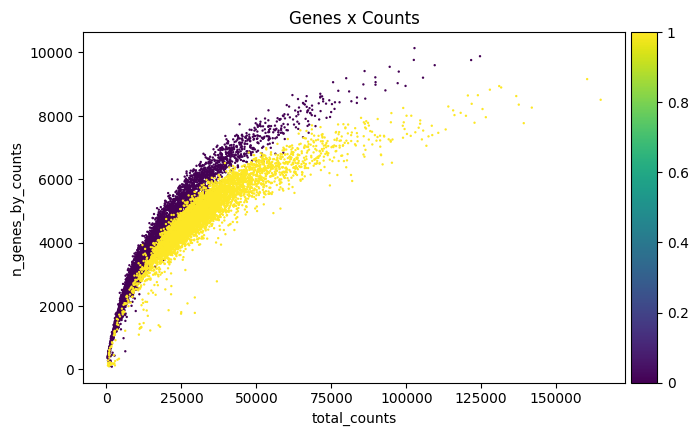

In [13]:
ax = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='cell_state_encoded', title='Genes x Counts', show=False)

(0.0, 5000.0)

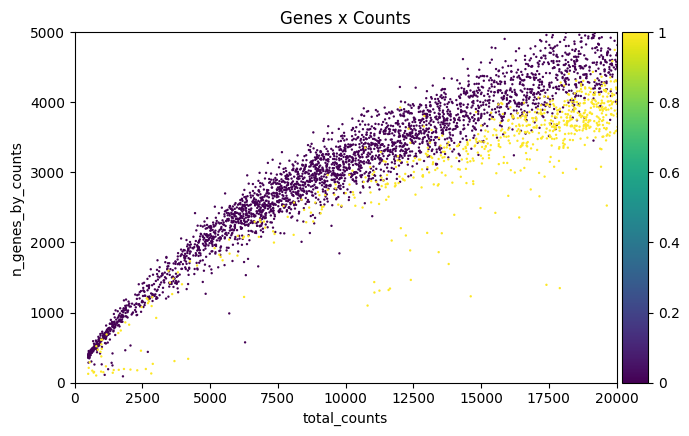

In [14]:
ax = sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='cell_state_encoded', title='Genes x Counts', show=False)
ax.set_xlim(0,20000)
ax.set_ylim(0,5000)

Vemos que células con unos 2500 conteos tienen 1000 genes expresados. Podemos poner el umbral entre 1000-2000 genes expresados?

## 4. Filter data

We can dedice new criteria to filter database: 

    (i) Total UMI counts less than 1000/2000 ? -> Represent the absolute number of observed transcripts (total count of RNA)
    (ii) Detected gene numbers less than 500 (expressed)
    (iii) Mitochondrial genes percentage more than 20 (% genic expression)-> because it can be dead and damaged cells, más o menos restrictivos? ribosomical and hemoglobine tmbn?

In [15]:
adata_filtered = adata.copy()
sc.pp.filter_cells(adata_filtered, min_genes=500)
sc.pp.filter_cells(adata_filtered, min_counts=1000)
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_mt < 20, :]
print(f"""{adata.shape[0] - adata_filtered.shape[0]} samples have been deleted. 
Data shape after filtering: {adata_filtered.shape}""")

227 samples have been deleted. 
Data shape after filtering: (10101, 32738)


## 5. Doublet detection

Doublet cell identification refers to the process of detecting and filtering out "doublets." A doublet occurs when two cells are mistakenly captured and sequenced as a single cell. This can lead to misleading results because the expression profile of a doublet will contain RNA from both cells, potentially distorting the true biological signal.

*Impact of Doublets*
1. False Expression Patterns: Doublets can artificially inflate the number of detected genes and total counts, as they represent the combined transcriptomes of two cells.
2. Misleading Biological Interpretation: They can lead to incorrect conclusions about cell types, states, and trajectories because the mixed signals can appear as novel or hybrid cell types.

*Mitigating Doublets*
1. Optimal Cell Loading: Adjusting the cell concentration during the loading process to minimize the chance of multiple cells being captured together.
2. Post-capture Analysis: Using doublet detection tools and stringent filtering criteria during the data analysis phase.

*Identifying Doublets*

Several strategies and computational tools are used to identify and remove doublets from scRNA-seq datasets:

1. Statistical Methods: Algorithms like Scrublet, DoubletFinder, and DoubletDetection use statistical models to predict the likelihood of each cell being a doublet based on the transcriptome profile.

    - Scrublet: Simulates doublets by adding the profiles of two random cells and then identifies real cells with similar profiles. https://doi.org/10.1016/j.cels.2018.11.005
    - DoubletFinder: Uses pre-existing clustering information to identify and score potential doublets. https://doi.org/10.1016/j.cels.2019.03.003
    - DoubletDetection: Utilizes a machine learning approach to classify doublets based on features derived from the data.
    - Expression Metrics: Cells with unusually high numbers of detected genes or total counts compared to the majority of cells in the dataset are flagged as potential doublets. These metrics can be visualized using violin plots, histograms, or scatter plots.

2. Marker Gene Expression: Checking for simultaneous expression of marker genes from different, mutually exclusive cell types can indicate doublets. For example, if a cell expresses high levels of both neuronal and immune cell markers, it might be a doublet.

3. Barcoding Techniques: Some newer technologies use genetic or chemical barcoding to label individual cells, making it easier to detect and exclude doublets based on barcode collisions.


### 5.1 Scrublet

Preprocessing...


/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 38.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.1%
Elapsed time: 11.4 seconds


/tmp/ipykernel_1246284/3967561762.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filtered.obs['predicted_doublet'] = predicted_doublets


Running UMAP...


/home/alopez/anaconda3/envs/r_env/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(<Figure size 800x400 with 3 Axes>,
 array([<Axes: title={'center': 'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

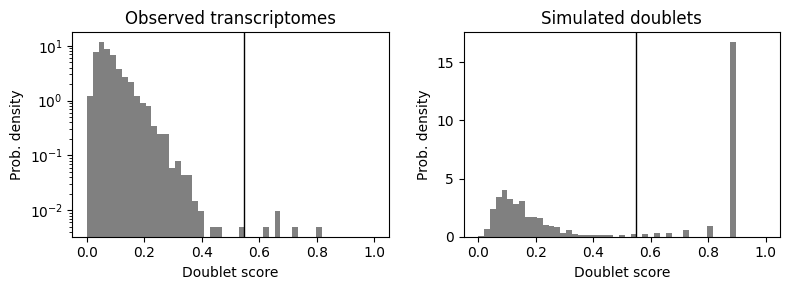

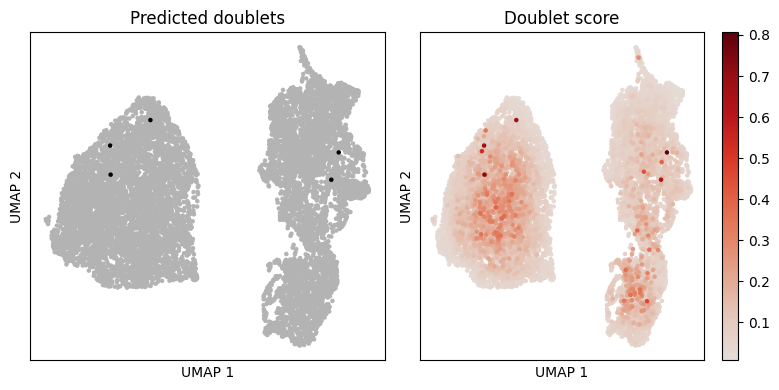

In [16]:
# This is the method that Scrublet uses to identify doublets - it assumes a bimodal distribution of doublet scores. 
# Those droplets with lower scores should be singlets and those with higher scores should be doublets. 
# It identifies the correct threshold by identifying the minimum of the bimodal distribution of simulated doublets.
# However, sometimes there is not a good bimodal distribution and sometimes you will have to set the threshold manually.!!!!


# n_neighbors set as default value: round(0.5*sqrt(n_cells)) = 50 -> same as paper
# Matrix containing raw (unnormalized) UMI-based transcript counts
scrub = scr.Scrublet(adata_filtered.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30) # 20 in paper

adata_filtered.obs['predicted_doublet'] = predicted_doublets
adata_filtered.obs['doublet_score'] = doublet_scores
# Distribution of doublets scores for all cells. The doublet scores
# are continuous values that indicate the probability that a cell is a doublet (threshold for separating populations).
# Automatic threshold: this is set automatically by looking for the minimum between the two modes of the doublet_scores_sim_ histogram.
scrub.plot_histogram()
# Do not look like good results 
print('Running UMAP...')
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)

In [17]:
# If we decide that these doublets are correct we must delete these samples

### 5.2 DoubletDetection

In [18]:
import doubletdetection

adata_without_doublets = adata_filtered.copy()

clf = doubletdetection.BoostClassifier(n_iters=10, clustering_algorithm='phenograph', standard_scaling=True, verbose = True)
doublets = clf.fit(adata_without_doublets.X).predict(p_thresh=1e-16, voter_thresh=50)

doublet_score = clf.doublet_score()

adata_without_doublets.obs["doublet"] = doublets
adata_without_doublets.obs["doublet_score"] = doublet_score

Sparsifying matrix.


  0%|          | 0/10 [00:00<?, ?it/s]

Iteration   1/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 10%|█         | 1/10 [00:10<01:33, 10.34s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9854676723480225 seconds
Jaccard graph constructed in 2.6651501655578613 seconds
Wrote graph to binary file in 0.047353267669677734 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.881285
Louvain completed 21 runs in 1.6660962104797363 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.141540288925171 seconds

Found clusters [-1, ... 25], with sizes: [64, 1947, 1144, 946, 928, 812, 705, 703, 641, 570, 497, 479, 437, 383, 355, 346, 315, 238, 211, 200, 200, 131, 115, 102, 63, 52, 42]

Iteration   2/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 20%|██        | 2/10 [00:21<01:24, 10.56s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.048449754714966 seconds
Jaccard graph constructed in 2.6436874866485596 seconds
Wrote graph to binary file in 0.0485842227935791 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.879062
After 3 runs, maximum modularity is Q = 0.882318
Louvain completed 23 runs in 1.9311513900756836 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.394005298614502 seconds

Found clusters [-1, ... 24], with sizes: [63, 1999, 1273, 1159, 905, 821, 742, 601, 579, 567, 493, 414, 401, 399, 360, 318, 304, 224, 191, 180, 138, 136, 135, 105, 68, 51]

Iteration   3/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 30%|███       | 3/10 [00:32<01:15, 10.81s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9750449657440186 seconds
Jaccard graph constructed in 2.6537423133850098 seconds
Wrote graph to binary file in 0.04840350151062012 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.880782
After 11 runs, maximum modularity is Q = 0.883051
Louvain completed 31 runs in 2.536349296569824 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.974170446395874 seconds

Found clusters [-1, ... 25], with sizes: [61, 1941, 1313, 969, 875, 801, 752, 697, 695, 628, 500, 491, 401, 390, 363, 350, 261, 185, 165, 141, 138, 123, 105, 102, 77, 62, 40]

Iteration   4/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 40%|████      | 4/10 [00:42<01:04, 10.74s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9556758403778076 seconds
Jaccard graph constructed in 2.660142183303833 seconds
Wrote graph to binary file in 0.05008745193481445 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.879792
After 2 runs, maximum modularity is Q = 0.881192
Louvain completed 22 runs in 1.883113145828247 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.345606803894043 seconds

Found clusters [-1, ... 23], with sizes: [54, 2180, 1548, 1179, 910, 885, 854, 758, 566, 543, 509, 449, 424, 295, 213, 186, 185, 163, 162, 146, 138, 94, 82, 62, 41]

Iteration   5/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 50%|█████     | 5/10 [00:53<00:52, 10.57s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9203481674194336 seconds
Jaccard graph constructed in 2.699719190597534 seconds
Wrote graph to binary file in 0.051172494888305664 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.880003
Louvain completed 21 runs in 1.7059972286224365 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.10048794746399 seconds

Found clusters [-1, ... 26], with sizes: [60, 2090, 1285, 1022, 861, 851, 632, 630, 569, 530, 505, 492, 406, 385, 312, 302, 256, 237, 212, 187, 173, 138, 134, 106, 95, 62, 54, 40]

Iteration   6/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 60%|██████    | 6/10 [01:03<00:42, 10.53s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8979692459106445 seconds
Jaccard graph constructed in 2.6496100425720215 seconds
Wrote graph to binary file in 0.0471193790435791 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.879599
After 3 runs, maximum modularity is Q = 0.881334
Louvain completed 23 runs in 1.9239907264709473 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.168270349502563 seconds

Found clusters [-1, ... 24], with sizes: [68, 1978, 1172, 1163, 852, 843, 778, 748, 645, 581, 486, 428, 415, 337, 331, 310, 296, 191, 186, 176, 152, 141, 140, 106, 61, 42]

Iteration   7/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 70%|███████   | 7/10 [01:14<00:32, 10.75s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8996219635009766 seconds
Jaccard graph constructed in 2.6826512813568115 seconds
Wrote graph to binary file in 0.05056571960449219 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.882018
After 15 runs, maximum modularity is Q = 0.883269
Louvain completed 35 runs in 2.768850326538086 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.969542980194092 seconds

Found clusters [-1, ... 24], with sizes: [54, 1611, 1492, 1275, 902, 836, 799, 614, 610, 598, 595, 520, 463, 385, 308, 250, 181, 178, 174, 168, 140, 139, 134, 97, 62, 41]

Iteration   8/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 80%|████████  | 8/10 [01:25<00:21, 10.65s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9280638694763184 seconds
Jaccard graph constructed in 2.6674349308013916 seconds
Wrote graph to binary file in 0.04836678504943848 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.883769
Louvain completed 21 runs in 1.774836540222168 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.19194221496582 seconds

Found clusters [-1, ... 25], with sizes: [72, 1837, 1598, 1317, 899, 818, 672, 645, 639, 558, 477, 476, 444, 333, 291, 270, 240, 171, 169, 143, 137, 106, 104, 64, 54, 50, 42]

Iteration   9/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



 90%|█████████ | 9/10 [01:35<00:10, 10.65s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.9441337585449219 seconds
Jaccard graph constructed in 2.6801583766937256 seconds
Wrote graph to binary file in 0.048508405685424805 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.878146
After 2 runs, maximum modularity is Q = 0.881272
Louvain completed 22 runs in 1.8863656520843506 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.44127869606018 seconds

Found clusters [-1, ... 24], with sizes: [72, 2219, 1133, 979, 927, 908, 822, 774, 686, 653, 440, 429, 411, 303, 273, 239, 210, 204, 187, 172, 158, 139, 131, 62, 50, 45]

Iteration  10/10

Creating synthetic doublets...
Normalizing...
Running PCA...
Clustering augmented data set...



100%|██████████| 10/10 [01:46<00:00, 10.67s/it]

Setting directed=False because prune=True
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 1.8811724185943604 seconds
Jaccard graph constructed in 2.6595993041992188 seconds
Wrote graph to binary file in 0.04815793037414551 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.880178
After 6 runs, maximum modularity is Q = 0.881598
Louvain completed 26 runs in 2.171882390975952 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 8.63407826423645 seconds

Found clusters [-1, ... 22], with sizes: [71, 2114, 1169, 1169, 1002, 898, 868, 699, 638, 623, 499, 478, 368, 300, 286, 281, 269, 178, 170, 165, 140, 134, 64, 43]



In [39]:
# 1.0, "doublet"
# 0.0, "singlet"
results = pd.Series(doublets, name="DoubletDetection_DropletType")
results.replace({1.0: "doublet",  0.0: "singlet"}, inplace=True)
results.value_counts()

DoubletDetection_DropletType
singlet    10081
Name: count, dtype: int64

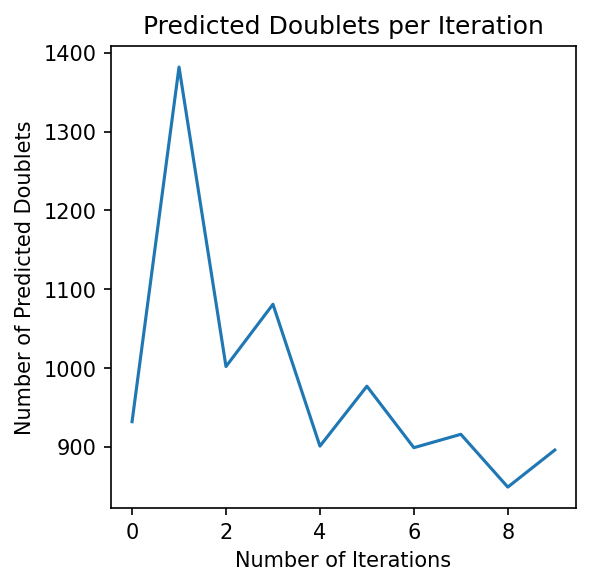

In [19]:
doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

## 6. Empty-drop identification

It estimates the background levels of RNA present in empty droplets, then identifies droplets containing cell that significantly deviate from the background.

emptyDrops() in R, uses a statistical model based on the Poisson distribution. 

To identify empty drops, it would be most appropriate to use the distribution of counts (per cell) to define a threshold.

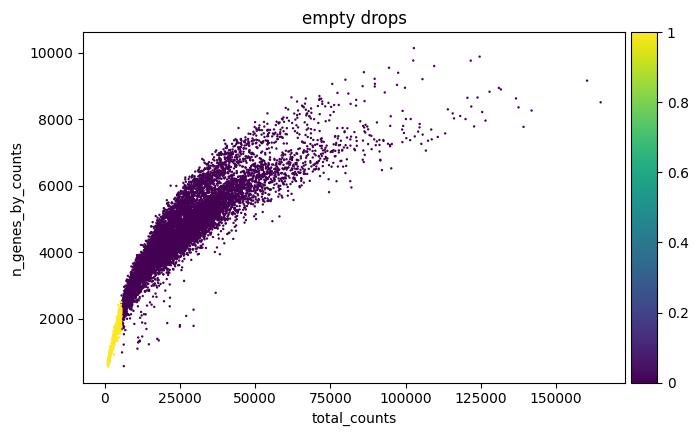

In [18]:
# After normalization? 
# Empty droplet identification
# Calculate the total sum of counts for each cell
total_counts = np.array(adata_filtered.X.sum(axis=1)).flatten()

# Set a threshold to detect empty drops-> TODO: Which threshold to use?
threshold = np.percentile(total_counts, 5)  # For example, the 5th percentile

# Identify empty droplets
empty_drops = total_counts < threshold

# Save results
adata_filtered.obs['empty_drops'] = empty_drops

# Visualize
sc.pl.scatter(adata_filtered, x='total_counts', y='n_genes_by_counts', color='empty_drops')

In [19]:
# If we decide that these samples are empty we must delete them.

## 7. Normalization

The log-transformation is useful as differences in the log-values represent log-fold changes in expression. This is important in downstream procedures based on Euclidean distances, which includes many forms of clustering and dimensionality reduction. By operating on log-transformed data, we ensure that these procedures are measuring distances between cells based on log-fold changes in expression. Or in other words, which is more interesting - a gene that is expressed at an average count of 50 in cell type A and 10 in cell type B or a gene that is expressed at an average count of 1100 in A and 1000 in B? Log-transformation focuses on the former by promoting contributions from genes with strong relative differences.

When log-transforming, we typically add a pseudo-count to avoid undefined values at zero. Larger pseudo-counts will effectively shrink the log-fold changes between cells towards zero for low-abundance genes, meaning that downstream high-dimensional analyses will be driven more by differences in expression for high-abundance genes. Conversely, smaller pseudo-counts will increase the relative contribution of low-abundance genes. Common practice is to use a pseudo-count of 1, for the simple pragmatic reason that it preserves sparsity in the original matrix (i.e., zeroes in the input remain zeroes after transformation). This works well in all but the most pathological scenarios (A. Lun 2018).

Incidentally, the addition of the pseudo-count is the motivation for the centering of the size factors at unity. This ensures that both the pseudo-count and the normalized expression values are on the same scale; a pseudo-count of 1 can be interpreted as an extra read or UMI for each gene. In practical terms, centering means that the shrinkage effect of the pseudo-count diminishes as sequencing depth improves. This correctly ensures that estimates of the log-fold change in expression (e.g., from differences in the log-values between groups of cells) become increasingly accurate with deeper coverage. In contrast, if we applied a constant pseudo-count to some count-per-million-like measure, accuracy of the subsequent log-fold changes would never improve regardless of how much additional sequencing we performed.

In [20]:
# Normalize data so that the total count per cell is equal to 10,000 (scale factor)
normalized_data = adata_filtered.copy()
sc.pp.normalize_total(normalized_data, target_sum=1e4)
# log n+1 transformation
sc.pp.log1p(normalized_data)

In [21]:
# Save AnnData Objects -> do UMAP after using it
# Filtering 
adata_filtered.write_h5ad("./data/filtered_data.h5ad.gz", compression="gzip")
# Filtering  + Normalized
normalized_data.write_h5ad("./data/filtered_normalized_data.h5ad.gz", compression="gzip")

In [22]:
scaled_data = normalized_data.copy()
# Max value to return for scaled data. Setting this can help reduce the effects of features that are only expressed in a very small number of cells
sc.pp.scale(scaled_data, max_value=10)
# Filtering  + Normalized + Scaled
scaled_data.write_h5ad("./data/scaled_data.h5ad.gz", compression="gzip")

## 8. Feature selection

https://docs.google.com/presentation/d/19J2FyjKlBQdAkku4Oa6UZ6SA-Y4P7AEKCRIbEQWA9ho/edit#slide=id.ga100bba375887aa_897

Calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others) because focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

https://doi.org/10.1016/j.cell.2019.05.031

This method models the mean-variance relationship inherent in single-cell data.

"*In each dataset, we next aimed to identify a subset of features (e.g., genes) exhibiting high variability across cells, and therefore represent heterogeneous features to prioritize for downstream analysis. Choosing genes solely based on their log-normalized single-cell variance fails to account for the mean-variance relationship that is inherent to single-cell RNA-seq. Therefore, we first applied a variance-stabilizing transformation to correct for this [Mayer et al., 2018, Hafemeister and Satija, 2019].*
*To learn the mean-variance relationship from the data, we computed the mean and variance of each gene using the unnormalized data (i.e., UMI or counts matrix), and applied log10 -transformation to both. We then fit a curve to predict the variance of each gene as a function of its mean, by calculating a local fitting of polynomials of degree 2 (R function loess, span = 0.3). This global fit provided us with a regularized estimator of variance given the mean of a feature. As such, we could use it to standardize feature counts without removing higher-than-expected variation. Given the expected variances, we performed the transformation zij=xij−x¯iσi.*

*This variance represents a measure of single-cell dispersion after controlling for mean expression, and we use it directly to rank the features. Unless otherwise noted, we selected the 2,000 genes with the highest standardized variance as “highly variable.” This procedure is implemented in the FindVariableFeatures function in Seurat v3 (selection.method = “vst”).*"

Number of highly variable genes: 919


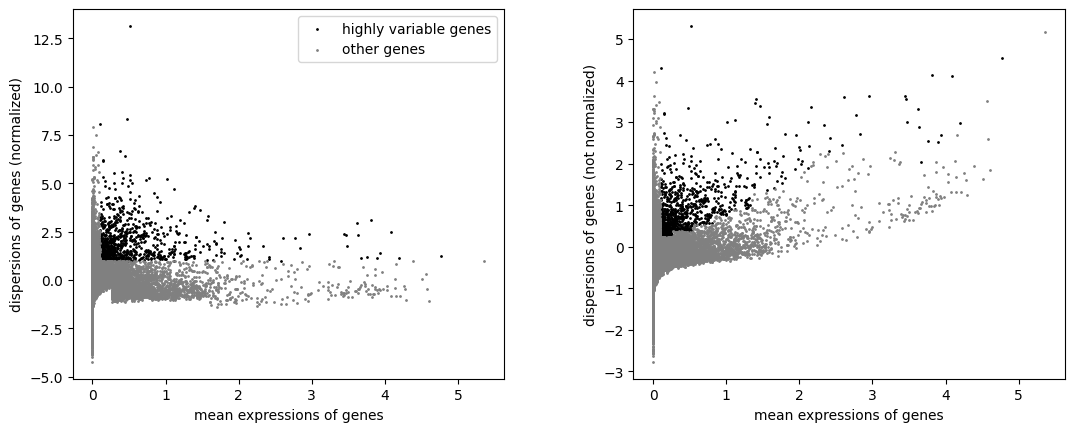

In [23]:
# Identify highly variable genes (HVGs) -> Expects logarithmized data
HVG_data = normalized_data.copy()

sc.pp.highly_variable_genes(
        HVG_data,
        flavor="seurat",
        # n_top_genes=2000, # limitan el número a de genes variables a 2000
        span=0.3,
        n_bins=20,
        min_mean=0.1,
        max_mean=8,
        min_disp=1,
        max_disp=float('inf')
    ) 

print(f"Number of highly variable genes: {HVG_data.var['highly_variable'].sum()}")
sc.pl.highly_variable_genes(HVG_data)

# Filter expression matrix to include only genes with high variability.
HVG_data = HVG_data[:, HVG_data.var.highly_variable]

## 9. Scaling

In [22]:
pcHVG_data = HVG_data.copy()
# Max value to return for scaled data. Setting this can help reduce the effects of features that are only expressed in a very small number of cells
sc.pp.scale(pcHVG_data, max_value=10)

In [22]:
# Save AnnData Objects -> do UMAP after using it
# Filtering + High Variable Genes
HVG_data.write_h5ad("./data/HVG_data.h5ad.gz", compression="gzip")
# Filtering + High Variable Genes + Z-Score 
pcHVG_data.write_h5ad("./data/pcHVG_data.h5ad.gz", compression="gzip")